In [43]:
# Installing required package
!pip install yfinance --quiet

# Importing essential libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Displaying all columns while printing DataFrames
pd.set_option('display.max_columns', None)


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
tickers = {
    'TCS': 'TCS.NS',
    'INFY': 'INFY.NS',
    'HCLTECH': 'HCLTECH.NS',
    'WIPRO': 'WIPRO.NS',
    'TECHM': 'TECHM.NS',
    'LTIM': 'LTIM.NS',
    'MPHASIS': 'MPHASIS.NS',
    
    'PERSISTENT': 'PERSISTENT.NS',
    'COFORGE': 'COFORGE.NS',
    'OFSS': 'OFSS.NS'
}

nifty_it = '^CNXIT'

tickers = list(tickers.values())

print(tickers)

['TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'LTIM.NS', 'MPHASIS.NS', 'PERSISTENT.NS', 'COFORGE.NS', 'OFSS.NS']


In [50]:
# Downloading 10 years of historical daily data correctly for adjusted close prices
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', auto_adjust=True)

nifty_it_data = yf.download(nifty_it, start='2015-01-01', end='2025-01-01', auto_adjust=True)

# 'auto_adjust=True' means downloaded data is already adjusted for splits/dividends, so we can directly use the 'Close' column and the result will already be a DataFrame of Close prices

# Displaying the first few rows
data.head()
nifty_it_data.head()
print(nifty_it_data.shape)
print(data.shape)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed

(2170, 5)
(2467, 50)


In [52]:
# Computing log returns
log_returns = np.log(data["Close"] / data.shift(1)["Close"]).dropna()

index_ret = np.log(nifty_it_data["Close"] / nifty_it_data.shift(1)["Close"]).dropna()

index_ret = index_ret.loc[log_returns.index.intersection(index_ret.index)]

# Displaying first few rows of log returns
log_returns.head()
print(log_returns.shape)
index_ret.head()
print(index_ret.shape)

(1975, 10)
(1975, 1)


In [64]:

import cvxpy as cp
import numpy as np

def optimise():
    R = log_returns.values 
    I = index_ret.values.flatten() 

    w = cp.Variable(10)

    objective = cp.Minimize(cp.norm(R @ w - I, 2))
    one = np.ones(10)
    constraints = [w >= 0, w.T @ one == 1]

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    err = prob.solve()

    return err, w.value

# Run optimization
err, weights = optimise()
print("Tracking error:", err)
print("Optimal weights:", weights)


Tracking error: 0.07427641870304659
Optimal weights: [0.03240937 0.12461846 0.26800918 0.03279018 0.02914494 0.01652902
 0.01817442 0.26154179 0.11175976 0.10502289]


In [65]:
recent_returns = log_returns.tail(60)    # approx. 3 months of trading days (~20 per month)
recent_index = index_ret.loc[recent_returns.index]

# Define month 1 and month 2
period1 = recent_returns.iloc[:20]
period2 = recent_returns.iloc[20:40]

index1 = recent_index.iloc[:20]
index2 = recent_index.iloc[20:40]

# --- Define optimization function ---
def optimise_period(log_ret_period, index_ret_period):
    R = log_ret_period.values
    I = index_ret_period.values.flatten()

    w = cp.Variable(R.shape[1])
    objective = cp.Minimize(cp.norm(R @ w - I, 2))
    constraints = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(objective, constraints)
    err = prob.solve()
    return err, w.value

err1, w1 = optimise_period(period1, index1)
err2, w2 = optimise_period(period2, index2)

print("Tracking error (Month 1):", err1)
print("Tracking error (Month 2):", err2)
print("\nWeights Month 1:\n", w1)
print("\nWeights Month 2:\n", w2)

# --- Compute rebalancing requirement ---
rebalancing = np.abs(w2 - w1)
print("\nRebalancing required (absolute change per stock):\n", rebalancing)
print("\nTotal turnover required:", np.sum(rebalancing))

# --- Evaluate out-of-sample tracking performance (next month) ---
# We'll use the *next* 20 days (Month 3) as out-of-sample test
period3 = recent_returns.iloc[40:60]
index3 = recent_index.iloc[40:60]

# Portfolio returns with Month 1 and Month 2 weights
portfolio1_ret = period3 @ w1
portfolio2_ret = period3 @ w2

# Compute tracking errors
te1 = np.sqrt(np.mean((portfolio1_ret.values.flatten() - index3.values.flatten())**2))
te2 = np.sqrt(np.mean((portfolio2_ret.values.flatten() - index3.values.flatten())**2))

print("\nOut-of-sample tracking error:")
print("Month 1 portfolio:", te1)
print("Month 2 portfolio:", te2)


Tracking error (Month 1): 0.002564080055243144
Tracking error (Month 2): 0.0005801826193499278

Weights Month 1:
 [1.92844236e-02 8.56331268e-02 2.71482655e-01 5.77351884e-02
 1.44200636e-02 2.14731821e-09 8.90118443e-02 2.75906113e-01
 1.37211223e-01 4.93153605e-02]

Weights Month 2:
 [5.68026985e-02 1.08041607e-01 2.72388400e-01 5.74869686e-02
 3.64825040e-02 1.87680277e-09 6.77024771e-02 2.33372626e-01
 9.75012651e-02 7.02214508e-02]

Rebalancing required (absolute change per stock):
 [3.75182749e-02 2.24084805e-02 9.05745642e-04 2.48219774e-04
 2.20624404e-02 2.70515433e-10 2.13093673e-02 4.25334867e-02
 3.97099577e-02 2.09060903e-02]

Total turnover required: 0.2076020634585012

Out-of-sample tracking error:
Month 1 portfolio: 0.00063177913313192
Month 2 portfolio: 0.00018522344878627126


[*********************100%***********************]  1 of 1 completed


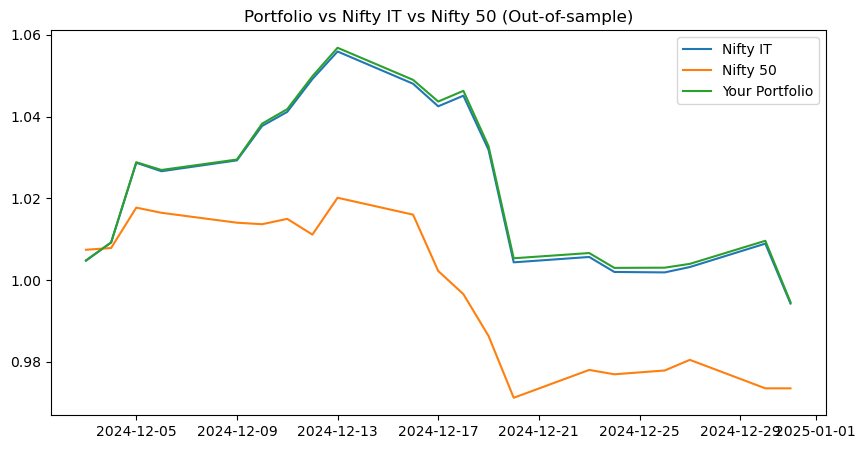

In [66]:
# Download Nifty 50 benchmark
nifty50_data = yf.download("^NSEI", start='2015-01-01', end='2025-01-01', auto_adjust=True)
nifty50_ret = np.log(nifty50_data["Close"] / nifty50_data["Close"].shift(1)).dropna()
nifty50_ret = nifty50_ret.loc[index_ret.index]

# Compare performance visually
plt.figure(figsize=(10,5))
plt.plot((1 + index3).cumprod(), label='Nifty IT')
plt.plot((1 + nifty50_ret.loc[index3.index]).cumprod(), label='Nifty 50')
plt.plot((1 + portfolio2_ret).cumprod(), label='Your Portfolio')
plt.legend()
plt.title("Portfolio vs Nifty IT vs Nifty 50 (Out-of-sample)")
plt.show()


Returns: [(1, 0.14400737882388), (2, 0.11938876256361812), (3, 0.11399724513960921), (4, 0.1481859011465678), (5, 0.1739259001443232), (6, 0.18664568698517692), (7, 0.18244301010657657), (8, 0.18606374458558383), (9, 0.18547583637742043), (10, 0.18547583637742046)]

Variances: [(1, 0.06158218484036251), (2, 0.03755798114989023), (3, 0.03365325476097694), (4, 0.035774092346381584), (5,0.03169625723728521), (6, 0.02943031452955449), (7, 0.028049918332331142), (8, 0.02719215116707048), (9, 0.02725628392508261), (10, 0.027256283925082617)]